In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.3807

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - loss: 0.3182
Average validation loss: 0.6167653799057007
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - loss: 0.3182 - val_loss: 0.6168
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - loss: 0.2449 - val_loss: 0.6168
Average validation loss: 0.30972135066986084
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - loss: 0.2449 - val_loss: 0.4632
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - loss: 0.1934 - val_loss: 0.4632
Average validation loss: 0.3581656813621521
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - loss: 0.1934 - val_loss: 0.4282
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - loss: 0.1606 - val_loss: 0.4282
Average validation loss: 0.271

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - loss: 0.0279
Average validation loss: 0.2584555894136429
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - loss: 0.0279 - val_loss: 0.2585
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - loss: 0.0251 - val_loss: 0.2585
Average validation loss: 0.12153036519885063
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - loss: 0.0251 - val_loss: 0.1900
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - loss: 0.0231 - val_loss: 0.1900
Average validation loss: 0.10084784403443336
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0231 - val_loss: 0.1603
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - loss: 0.0138
Average validation loss: 0.054714806067446865
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - loss: 0.0138 - val_loss: 0.0547
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - loss: 0.0121 - val_loss: 0.0547
Average validation loss: 0.04791627296557029
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - loss: 0.0121 - val_loss: 0.0513
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step - loss: 0.0103 - val_loss: 0.0513
Average validation loss: 0.06750319401423137
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - loss: 0.0103 - val_loss: 0.0567
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - loss: 0.0093 - val_loss: 0.0567
Averag

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - loss: 0.0050
Average validation loss: 0.015519509732257575
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 501ms/step - loss: 0.0050 - val_loss: 0.0155
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - loss: 0.0043 - val_loss: 0.0155
Average validation loss: 0.055604582419618964
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - loss: 0.0043 - val_loss: 0.0356
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 489ms/step - loss: 0.0038 - val_loss: 0.0356
Average validation loss: 0.009088034450542182
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - loss: 0.0038 - val_loss: 0.0267
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - loss: 0.0035 - val_loss: 0.0267
Aver

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step - loss: 0.0090
Average validation loss: 0.0071320543764159085
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - loss: 0.0090 - val_loss: 0.0071
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - loss: 0.0065 - val_loss: 0.0071
Average validation loss: 0.006103622354567051
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - loss: 0.0065 - val_loss: 0.0066
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - loss: 0.0053 - val_loss: 0.0066
Average validation loss: 0.0038221231312491
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 494ms/step - loss: 0.0053 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - loss: 0.0085
Average validation loss: 0.015863370421963435
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - loss: 0.0085 - val_loss: 0.0159
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - loss: 0.0072 - val_loss: 0.0159
Average validation loss: 0.00437507275880004
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 495ms/step - loss: 0.0072 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 486ms/step - loss: 0.0059 - val_loss: 0.0101
Average validation loss: 0.002766367756218339
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 495ms/step - loss: 0.0059 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - loss: 0.0082
Average validation loss: 0.03357935515232384
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - loss: 0.0082 - val_loss: 0.0336
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 486ms/step - loss: 0.0063 - val_loss: 0.0336
Average validation loss: 0.012983870145399123
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - loss: 0.0063 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 489ms/step - loss: 0.0053 - val_loss: 0.0233
Average validation loss: 0.018251017553848215
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 497ms/step - loss: 0.0053 - val_loss: 0.0216
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 488ms/step - loss: 0.0046 - val_loss: 0.0216
Ave

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 489ms/step - loss: 0.0052
Average validation loss: 0.005748607819744696
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - loss: 0.0052 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 489ms/step - loss: 0.0038 - val_loss: 0.0057
Average validation loss: 0.004203268627558525
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - loss: 0.0038 - val_loss: 0.0050
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 490ms/step - loss: 0.0031 - val_loss: 0.0050
Average validation loss: 0.003518748800464285
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - loss: 0.0031 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 488ms/step - loss: 0.0037
Average validation loss: 0.019067215134522746
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 497ms/step - loss: 0.0037 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 490ms/step - loss: 0.0030 - val_loss: 0.0191
Average validation loss: 0.00661291230270373
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - loss: 0.0030 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 489ms/step - loss: 0.0027 - val_loss: 0.0128
Average validation loss: 0.016296948256370212
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 498ms/step - loss: 0.0027 - val_loss: 0.0140
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 489ms/step - loss: 0.0024 - val_loss: 0.0140
Av

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 489ms/step - loss: 0.0032
Average validation loss: 0.0062760135042481124
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - loss: 0.0032 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 487ms/step - loss: 0.0025 - val_loss: 0.0063
Average validation loss: 0.008259915197413648
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 496ms/step - loss: 0.0025 - val_loss: 0.0073
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 489ms/step - loss: 0.0022 - val_loss: 0.0073
Average validation loss: 0.007732436970400158
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 498ms/step - loss: 0.0022 - val_loss: 0.0074
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 489ms/step - loss: 0.0020 - val_loss: 0.0074
Average validation loss: 0.006246153890970163
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 498ms/step - loss: 0.0020 - val_loss: 0.0071
Saved model weights to 'c:\天_11157

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 487ms/step - loss: 0.0026
Average validation loss: 0.012261277405842621
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 496ms/step - loss: 0.0026 - val_loss: 0.0123
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 489ms/step - loss: 0.0021 - val_loss: 0.0123
Average validation loss: 0.009114442803062653
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - loss: 0.0021 - val_loss: 0.0107
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 490ms/step - loss: 0.0019 - val_loss: 0.0107
Average validation loss: 0.03471512528550294
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 498ms/step - loss: 0.0019 - val_loss: 0.0187
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 489ms/step - loss: 0.0019 - val_loss: 0.0187


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 488ms/step - loss: 0.0021
Average validation loss: 0.0034165386656241025
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - loss: 0.0021 - val_loss: 0.0034
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 489ms/step - loss: 0.0018 - val_loss: 0.0034
Average validation loss: 0.0061050007469020786
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 497ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 490ms/step - loss: 0.0017 - val_loss: 0.0048
Average validation loss: 0.004483230935875326
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 498ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 487ms/step - loss: 0.0015 - val_loss: 0.0047
Average validation loss: 0.002000440451229224
80/80 ━━━━━━━━━━━━━━━━━━━━ 159s 495ms/step - loss: 0.0015 - val_loss: 0.0040
Saved model weights to 'c:\天_1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 489ms/step - loss: 0.0029
Average validation loss: 0.010313463588924302
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - loss: 0.0029 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 486ms/step - loss: 0.0023 - val_loss: 0.0103
Average validation loss: 0.016959939947507035
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 494ms/step - loss: 0.0023 - val_loss: 0.0136
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 489ms/step - loss: 0.0021 - val_loss: 0.0136
Average validation loss: 0.06428120168857276
96/96 ━━━━━━━━━━━━━━━━━━━━ 143s 498ms/step - loss: 0.0021 - val_loss: 0.0305
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 190s 489ms/step - loss: 0.0019 - val_loss: 0.0305
Average validation loss: 0.019267756123250972
96/96 ━━━━━━━━━━━━━━━━━━━━ 191s 498ms/step - loss: 0.0019 - val_loss: 0.0277
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 59s 490ms/step - loss: 0.0045
Average validation loss: 0.006887505942722782
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 499ms/step - loss: 0.0045 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 118s 488ms/step - loss: 0.0037 - val_loss: 0.0069
Average validation loss: 0.005499695009590747
120/120 ━━━━━━━━━━━━━━━━━━━━ 119s 496ms/step - loss: 0.0037 - val_loss: 0.0062
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 180s 504ms/step - loss: 0.0030 - val_loss: 0.0062
Average validation loss: 0.006389782964834012
120/120 ━━━━━━━━━━━━━━━━━━━━ 181s 513ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 241s 503ms/step - loss: 0.0028 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 490ms/step - loss: 0.0034
Average validation loss: 0.005906714942991837
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - loss: 0.0034 - val_loss: 0.0059
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 142s 490ms/step - loss: 0.0029 - val_loss: 0.0059
Average validation loss: 0.004177922686519903
144/144 ━━━━━━━━━━━━━━━━━━━━ 143s 498ms/step - loss: 0.0029 - val_loss: 0.0050
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 214s 490ms/step - loss: 0.0026 - val_loss: 0.0050
Average validation loss: 0.004716260567268667
144/144 ━━━━━━━━━━━━━━━━━━━━ 215s 498ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 286s 490ms/step - loss: 0.0023 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 491ms/step - loss: 0.0023
Average validation loss: 0.0066535755970107855
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 500ms/step - loss: 0.0023 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 158s 490ms/step - loss: 0.0020 - val_loss: 0.0067
Average validation loss: 0.004583005706081167
160/160 ━━━━━━━━━━━━━━━━━━━━ 160s 499ms/step - loss: 0.0020 - val_loss: 0.0056
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 238s 490ms/step - loss: 0.0018 - val_loss: 0.0056
Average validation loss: 0.010011958494578721
160/160 ━━━━━━━━━━━━━━━━━━━━ 240s 498ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 318s 490ms/step - loss: 0.0016

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 492ms/step - loss: 0.0031
Average validation loss: 0.004443938153854105
200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 500ms/step - loss: 0.0031 - val_loss: 0.0044
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 198s 490ms/step - loss: 0.0024 - val_loss: 0.0044
Average validation loss: 0.005728123203040241
200/200 ━━━━━━━━━━━━━━━━━━━━ 200s 498ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 298s 490ms/step - loss: 0.0021 - val_loss: 0.0051
Average validation loss: 0.009722449669304746
200/200 ━━━━━━━━━━━━━━━━━━━━ 299s 498ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 398s 491ms/step - loss: 0.0019 - val_loss: 0.0066
Average validation loss: 0.02520873387025631
200/200 ━━━━━━━━━━━━━━━━━━━━ 399s 500ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 5/10
200

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 118s 491ms/step - loss: 0.0022
Average validation loss: 0.006349240438274251
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - loss: 0.0022 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 237s 489ms/step - loss: 0.0018 - val_loss: 0.0063
Average validation loss: 0.006515377078557568
240/240 ━━━━━━━━━━━━━━━━━━━━ 239s 497ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 357s 491ms/step - loss: 0.0015 - val_loss: 0.0064
Average validation loss: 0.004498499725575511
240/240 ━━━━━━━━━━━━━━━━━━━━ 359s 499ms/step - loss: 0.0015 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_50\segformer_data_size_300.pth'.
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 476s 490ms/step - loss: 0.001

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.19408526428043843, 0.061354312524199484, 0.028355608104417715, 0.014402116150013172, 0.011175222665071488, 0.008448892969075434, 0.008885512478591408, 0.005382594468198174, 0.011750712856259529, 0.005972456482904818, 0.01040531132096981, 0.0052584130402537985, 0.006211520499030788, 0.006373081297584576, 0.014404590536112018, 0.01106638018404165, 0.013578874287707224, 0.006081164433308071]
std_val_losses =  [0.1624368095056703, 0.05539067104527715, 0.031869659367391986, 0.017708969363412635, 0.0213279850586777, 0.009209765258085074, 0.0077435433668621035, 0.005982076716538417, 0.02235979342369483, 0.006360767011486403, 0.01791570395343336, 0.0065612155981203055, 0.00952666009123728, 0.00836845448797561, 0.025779720158505142, 0.01591675606240646, 0.028478744072667497, 0.009854514740693113]


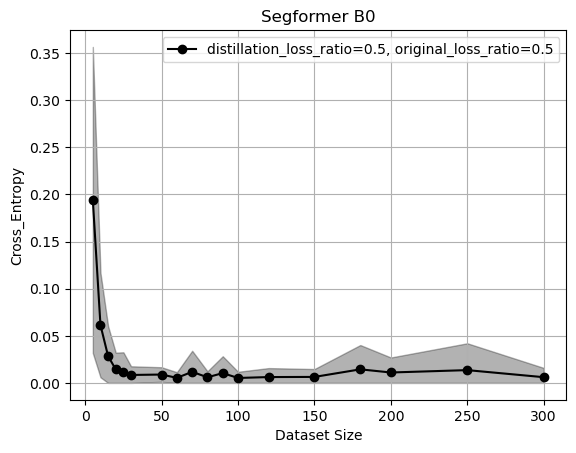

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()